# Initial setup, no 'big work'

Takes about 4 minutes to set up completely, press play and grad a coffee!

## Imports and setup

In [1]:
#standard imports, used throughout

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from time import time


# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D

plt.set_cmap('cividis')

#specific Neural Network imports

import tensorflow as tf
import keras
from keras import layers
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


#imports for scikit learn, for general ML techniques

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

from scipy.stats import norm
from scipy.integrate import simpson

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from sewar import ssim
from sewar import rmse

<Figure size 640x480 with 0 Axes>

In [2]:
cmap = matplotlib.cm.get_cmap('cividis')
colors = [cmap(i) for i in np.arange(0.1, 1.1, 0.1)]

In [3]:
def getData_profile(filename, outputs=[0], features_start=3):
    #read out the data from a csv file and remove n_period column

    data = pd.read_csv(filename, sep=',', header=0)

    if len(outputs)>1:
        y_df = data.iloc[:, outputs[0]:outputs[-1]+1]
    else:
        y_df = data.iloc[:, outputs[0]]
        
    X_df = data.iloc[:, features_start::]
        
    return y_df, X_df

In [4]:
y_df, X_df = getData_profile('sims_custom\dens_data_subtr.csv', outputs=[0, 1, 2])

#now split the first and last measurement distance into two different dataframes
X1_df, X2_df = X_df.iloc[:, :1023], X_df.iloc[:, 1023:]

In [5]:
def add_noise(img, var):
    '''Add random noise to an image'''

    noise = np.random.normal(0, var, img.shape)
    img_noised= noise + img
    return img_noised

In [6]:
def preProcessing_PCA(y_df, X_df, comps=5, absorb=True, test_size=0.2, random_state=0, noise=True, var_noise=0.01):
    #Do all the preprocessing steps for training and validation:
    #Remove absorber points
    #Properly expand dimensions
    #Split and renormalize to train max
    #add gaussian noise

    if absorb:
        RM_absorbers = VarianceThreshold()
        X_df = RM_absorbers.fit_transform(X_df)

    X = np.expand_dims(np.array(X_df), -1) #needed for the convolutional structure
    y = np.array(y_df)


    sss = ShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(sss.split(X, y[:, 0]))

    x_train, y_train = X[train_idx], y[train_idx]
    x_test, y_test = X[test_idx], y[test_idx]
    
    highest_peak = np.amax(abs(x_train))
    print(highest_peak)
    print(np.amin(x_train))
    x_train /= highest_peak
    x_test  /= highest_peak
    new_max = np.amax(abs(x_train))
    print(new_max)
    #get all the data to be normalized in a sense, to have the largest absolute value of 1
    #then the standard deviation of the noise you add is 1% of this max, quite substantial!
    
    if noise:
        for i, sample in enumerate(x_train):
            x_train[i] = add_noise(sample, var_noise*new_max)
        for i, sample in enumerate(x_test):
            x_test[i] = add_noise(sample, var_noise*new_max)

    pca = PCA(n_components=comps)
    pca.fit(x_train[:, :-1, 0])

    x_pca_train = pca.transform(x_train[:, :-1, 0])
    x_pca_test = pca.transform(x_test[:, :-1, 0])

    return x_train, x_pca_train, x_test, x_pca_test, y_train, y_test, pca

In [7]:
n_PCA_comps = 256

x_train, x_pca_train, x_test, x_pca_test, y_train, y_test, pca_model = preProcessing_PCA(y_df, X1_df, comps=n_PCA_comps, absorb=False, noise=True, var_noise=0.01)


503.0
-503.0
1.0


In [8]:
x_train_2, x_pca_train_2, x_test_2, x_pca_test_2, y_train, y_test, pca_model = preProcessing_PCA(y_df, X_df, comps=n_PCA_comps, absorb=False, noise=True)
x_train_2 = np.reshape(x_train_2, (x_train_2.shape[0], -1, 2))
x_test_2 = np.reshape(x_test_2, (x_test_2.shape[0], -1, 2))


503.0
-503.0
1.0


In [9]:
def reduce_dimension(arr, new_shape):

    #instead of just taking the hypergaussian at every 42nd place, it is perhaps better
    #to take the average over its values.
    
    row_size = arr.shape[0] // new_shape[0]
    col_size = arr.shape[1] // new_shape[1]
    new_arr = np.zeros(new_shape)
    for i in range(new_shape[0]):
        for j in range(new_shape[1]):
            start_row = i * row_size
            end_row = start_row + row_size
            start_col = j * col_size
            end_col = start_col + col_size
            new_arr[i][j] = arr[start_row:end_row, start_col:end_col].mean()
    return new_arr

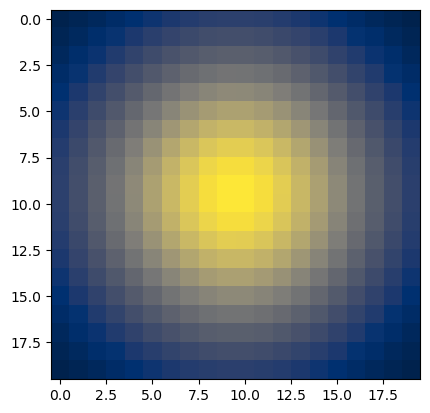

In [10]:
x = np.arange(0, 2048)
y = np.arange(0, 2048)

x = np.arange(605, 1445)
y = np.arange(605, 1445)

#x = np.arange(550, 1050, 26)
#y = np.arange(550, 1050, 26)

xv, yv = np.meshgrid(x, y, indexing='ij')


def gaussian(xv, yv, peak, pos_x, pos_y, stdev_x, stdev_y):
    return peak * np.exp(-((xv-pos_x)/np.sqrt(2)/stdev_x)**2 - ((yv-pos_y)/np.sqrt(2)/stdev_y)**2)

#the stdev is in number of wavelengths
#the divided by two is because this 64 is the n_period, so the amount of cells taken by a wavelength in the simulation
#but the output is only every second cell, so in the images below (which had originally 2048 values, now 1024) it needs to be halved

def hypergaussian(peak, expon, stdev_x=1, xv = xv, yv = yv, pos_x=1024, pos_y=1024):
    r2 = ((xv-pos_x)/np.sqrt(2)/(64*stdev_x))**2 + ((yv-pos_y)/np.sqrt(2)/(64*stdev_x))**2
    return peak * np.exp(-r2**expon)

def quartz(ne_peak = 1, xv = xv, yv = yv, radius_in=599.55, radius_out=666.18, pos_x=1024, pos_y=1024):

    bool1 = radius_in < np.sqrt((xv -pos_x)**2 + (yv -pos_y)**2)
    bool2 =  np.sqrt((xv -pos_x)**2 + (yv -pos_y)**2) < radius_out

    return np.where(bool1 & bool2, ne_peak/4, 0)


z2 = hypergaussian(0.8, 1, 3.5)


z2_red = reduce_dimension(z2, [20, 20])
quartz_pos = quartz()
plt.imshow(z2_red)

In [11]:
"""Making new training and testing data, by now having the output as the resolved images"""

y_train_new = np.array([reduce_dimension(hypergaussian(train_sample[0], train_sample[1], train_sample[2], xv=xv, yv=yv), [40, 40])
 for i, train_sample in enumerate(y_train)])
y_test_new = np.array([reduce_dimension(hypergaussian(test_sample[0], test_sample[1], test_sample[2], xv=xv, yv=yv), [40, 40])
 for i, test_sample in enumerate(y_test)])

#y_train_new = np.array([new_func(train_sample[0], train_sample[1]) for i, train_sample in enumerate(y_train)])
#y_test_new = np.array([new_func(test_sample[0], test_sample[1]) for i, test_sample in enumerate(y_test)])
#.reshape(400,)
y_train_new.shape

(2881, 40, 40)

## The compare functions

In [12]:
def compareProfiles():
    index = 0
    while index != -1:

        clear_output()
        plt.set_cmap('cividis')
        prediction = saved_parametric.predict({'profile': np.expand_dims(x_test[index], 0)})
        truth = y_test[index]

        x = np.arange(605, 1445)
        y = np.arange(605, 1445)

        xv, yv = np.meshgrid(x, y, indexing='ij')

        z_true = reduce_dimension(hypergaussian(truth[0], truth[1], truth[2], xv=xv, yv=yv), [40, 40])
        z_pred = reduce_dimension(hypergaussian(prediction[0], prediction[1], prediction[2], xv=xv, yv=yv), [40, 40])

        fig, ax = plt.subplots(1, 3, figsize=(11, 3))
        ax[0].fill_between(np.arange(0, 40), 0, np.diag(z_pred), color=colors[0], alpha=0.1)
        im_true = ax[0].plot(np.diag(z_true), label='Ground truth', linestyle='--', c='orange')
        ax[0].set_xlabel('Position on diagonal', fontsize=14)
        ax[0].set_ylabel(r'$n_e/n_{crit}$', fontsize=16)

        ax[0].plot(np.diag(z_pred), label='Prediction', c=colors[0])
        
        ax[0].set_xlim((0, 39))
        ax[0].set_ylim((0, 1))
        ax[0].legend(loc='upper left', fontsize=9)
        ax[0].tick_params(axis='both', which='major', labelsize=12)
        #//set the ticksize to 12 for the above figure ax[0]
        #plt.colorbar(im_true)

        max_value = np.max([z_true.max(), z_pred.max()])
        min_value = np.min([z_true.min(), z_pred.min()])

        #change to max and min_value to see more clear differences. But this maybe hits the point home
        #that we have really good agreement.
        true = ax[1].imshow(z_true, vmax=0.8, vmin=0)
        ax[1].set_title('True profile', fontsize=14)
        ax[1].tick_params(axis='both', which='major', labelsize=12)

        ax[2].imshow(z_pred, vmax=0.8, vmin=0)
        ax[2].set_title('Predicted profile', fontsize=14)
        ax[2].tick_params(axis='both', which='major', labelsize=12)

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.83, 0.13, 0.02, 0.725])
        cbar = fig.colorbar(true, cax=cbar_ax)
        cbar.ax.tick_params(labelsize=12)

        plt.show()


        index = int(input(f"Select new index, -1 to stop: "))

    return


In [13]:
def ResCompareProfiles(model, x, y, threeD=True):
    index = 0
    while index != -1:

        clear_output()
        plt.set_cmap('cividis')

        prediction = model.predict(np.expand_dims(x[index], 0)).reshape((40, 40))
        print(prediction.shape)
        truth = y[index].reshape((40, 40))


        fig, ax = plt.subplots(1, 3, figsize=(11, 3))

        ax[0].fill_between(np.arange(0, 40), 0, np.diag(prediction), color=colors[0], alpha=0.1)

        im_true = ax[0].plot(np.diag(truth), label='Ground truth', linestyle='--', c='orange')
        ax[0].set_xlabel('Position on diagonal', fontsize=14)
        ax[0].set_ylabel(r'$n_e/n_{crit}$', fontsize=16)

        ax[0].plot(np.diag(prediction), label='Prediction', c=colors[0])
        ax[0].set_xlim((0, 39))
        ax[0].set_ylim((0, 1))
        ax[0].legend(loc='upper left', fontsize=9)
        ax[0].tick_params(axis='both', which='major', labelsize=12)
        
        max_value = np.max([truth, prediction])
        min_value = np.min([truth, prediction])

        norm_true = (truth /max_value * 255).astype(int)
        norm_pred = (prediction /max_value * 255).astype(int)
        
        #true = ax[1].imshow(norm_true, vmax=255, vmin=(min_value*255).astype(int))
        true = ax[1].imshow(truth, vmax=0.8, vmin=0)
        ax[1].set_title('True plasma profile', fontsize=14)
        ax[1].tick_params(axis='both', which='major', labelsize=12)
        #ax[2].imshow(norm_pred, vmax=255, vmin=(min_value*255).astype(int))
        ax[2].imshow(prediction, vmax=0.8, vmin=0)
        ax[2].set_title('Predicted plasma profile', fontsize=14)
        ax[2].tick_params(axis='both', which='major', labelsize=12)

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.83, 0.13, 0.02, 0.725]) # [left, bottom, width, height] 
        #//make the cbar_ax above be abit closer to the ax[2] figure
        cbar = fig.colorbar(true, cax=cbar_ax)
        cbar.ax.tick_params(labelsize=12)

        print(cosine_similarity(norm_true, norm_pred))


        plt.show()

        if threeD: 
            fig = plt.figure(figsize=(8, 4))

            ax1 = fig.add_subplot(121, projection='3d')
            ax2 = fig.add_subplot(122, projection='3d')
            X, Y = np.meshgrid(np.arange(truth.shape[1]), np.arange(truth.shape[0]))
            ax1.plot_surface(X, Y, truth, vmax=0.8, vmin=0, cmap='cividis')
            ax1.set_zlim(0, 0.8)
            ax1.set_title('True profile')
            ax2.plot_surface(X, Y, prediction, vmax=0.8, vmin=0, cmap='cividis')
            ax2.set_zlim(0, 0.8)
            ax2.set_title('Predicted profile')

            plt.show()

        index = int(input(f"Select new index, -1 to stop: "))

    return


## The loss functions

In [14]:
import keras.backend as K

def mse(y_true, y_pred):
    # Define the custom loss function here
    mse = K.mean(K.square(y_true - y_pred))

    return mse 

def nrmse(y_true, y_pred):
    # Define the custom loss function here
    mse = K.mean(K.square(y_true - y_pred))
    rmse = K.sqrt(mse)
    min_val = K.min(y_true)
    max_val = K.max(y_true)
    return rmse / (max_val - min_val)



In [15]:
from skimage.metrics import structural_similarity as ssim

#non-differentiable, don't use for training!

def ssim_loss(y_true, y_pred):
    # Define the custom loss function here
    return  ssim(y_true, y_pred, multichannel=True)
    



In [16]:
#non-differentiable, don't use for training!

def psnr(y_true, y_pred):
    max_pixel = K.max(y_true)
    return 20 * K.log(max_pixel / K.sqrt(K.mean(K.square(y_true - y_pred)))) / K.log(10.0)

In [17]:
#non-differentiable, don't use for training!

from scipy.signal import correlate2d

def cross_correlation(y_true, y_pred):
    cross_corr = correlate2d(y_true, y_pred, mode='full')
    return cross_corr.max()

In [18]:
def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

In [19]:
def mape(y_true, y_pred):
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true), K.epsilon(), None))
    return 100. * K.mean(diff)

In [20]:
def cosine_similarity(y_true, y_pred):
    y_true = tf.cast(y_true,tf.float32)
    y_pred = tf.cast(y_pred,tf.float32)
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    cosine_similarity = 1 - K.sum(y_true * y_pred, axis=-1)
    return K.mean(cosine_similarity)


## Loading all the previously trained models

In [21]:
pca_saved_model_NN = load_model('NN_PCA.h5') #PCA model only predicting ne_peak
saved_parametric = load_model('custom_parametric.h5') #parametric model
saved_resolved = load_model('custom_resolved.h5') #resolved with RMSE
saved_resolved_a = load_model('custom_resolved_a.h5') #resolved with MAE
saved_resolved_2d = load_model('custom_resolved_2D.h5') #with double the input dimension
saved_resolved_PCA = load_model('custom_resolved_PCA.h5') #based on the first 256 pca components, without the first conv layers

In [22]:
#custom_loss = history_custom.history['val_ne_peak_loss'][-1]
[ne_pred_par, exp_pred_par, stdev_pred_par] = saved_parametric.predict({'profile': x_test})


23/23 [==============================] - 0s 6ms/step


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


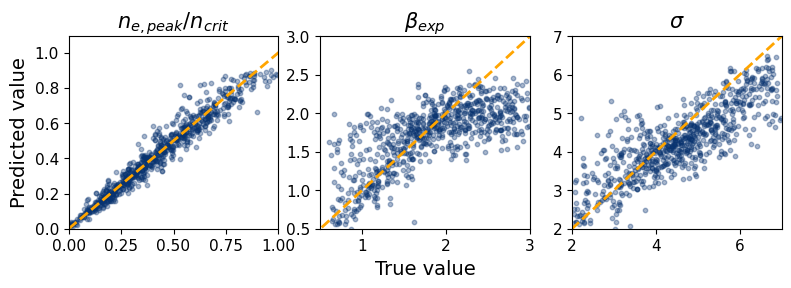

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(9.2, 2.5))

#// Get a single xlabel for all three subplots
ax[0].scatter(y_test[:, 0], ne_pred_par, s=10, c=colors[0], alpha=0.35)
xval_ne = np.linspace(0, ax[0].get_xlim()[1], 100)
yval_ne = np.linspace(0, ax[0].get_ylim()[1], 100)

ax[0].plot(xval_ne, xval_ne, ls="--", c='orange', linewidth=2)
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)
ax[0].set_title(r'$n_{e,peak}/n_{crit}$', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=11)
#ax[0].legend(loc='upper left', fontsize=12)
ax[0].set_ylabel('Predicted value', fontsize=14)

ax[1].scatter(y_test[:, 1], exp_pred_par, s=10, c=colors[0], alpha=0.35)
xval_exp = np.linspace(0, ax[1].get_xlim()[1], 100)
yval_exp = np.linspace(0, ax[1].get_ylim()[1], 100)

ax[1].plot(xval_exp, xval_exp, ls="--", c='orange', linewidth=2)
ax[1].set_xlim(0.5, 3)
ax[1].set_ylim(0.5, 3)
ax[1].set_title(r'$\beta_{exp}$', fontsize=15)
#ax[1].legend(loc='upper left', fontsize=12)
ax[1].set_xlabel('True value', fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=11)



ax[2].scatter(y_test[:, 2], stdev_pred_par, s=10, c=colors[0],alpha=0.35)
xval_stdev = np.linspace(0, ax[2].get_xlim()[1], 100)
yval_stdev = np.linspace(0, ax[2].get_ylim()[1], 100)

ax[2].plot(xval_stdev, xval_stdev, ls="--", c='orange', linewidth=2)
ax[2].set_xlim(2, 7)
ax[2].set_ylim(2, 7)
ax[2].set_title(r'$\sigma$', fontsize=15)
#ax[2].legend(loc='upper left', fontsize=12)
ax[2].tick_params(axis='both', which='major', labelsize=11)






In [195]:
12%10

2

## Plotting the outcomes

1/1 [==============================] - 0s 17ms/step


<Figure size 640x480 with 0 Axes>

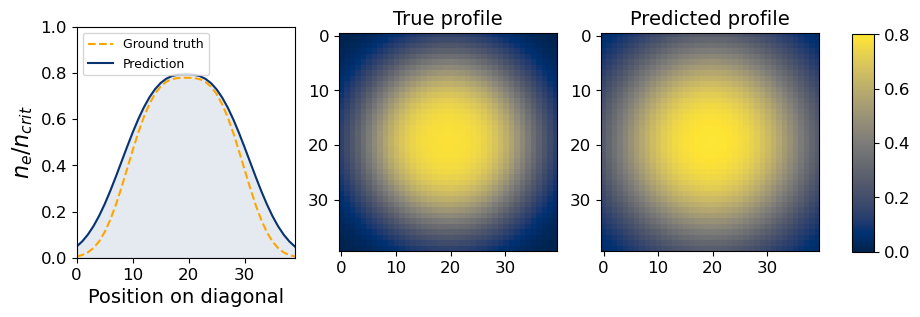

In [209]:
compareProfiles()

1/1 [==============================] - 0s 25ms/step
(40, 40)
tf.Tensor(0.0018722042, shape=(), dtype=float32)


<Figure size 640x480 with 0 Axes>

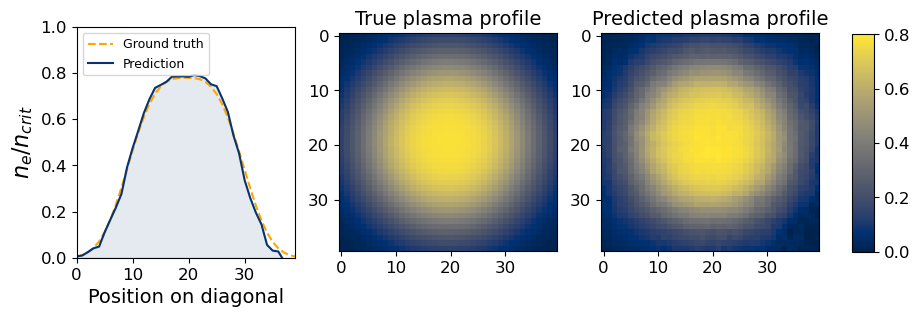

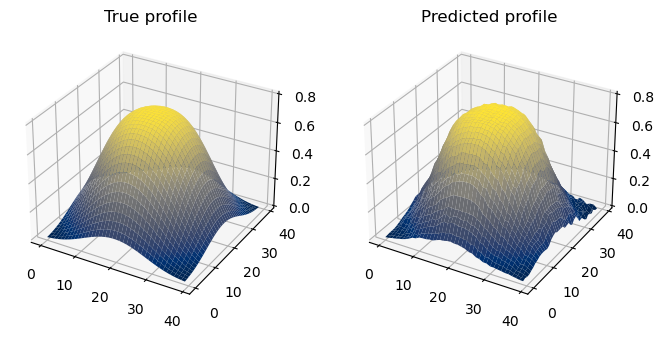

In [211]:
ResCompareProfiles(saved_resolved, x=x_test, y=y_test_new)

1/1 [==============================] - 0s 416ms/step
(40, 40)
tf.Tensor(0.0024935976, shape=(), dtype=float32)


<Figure size 640x480 with 0 Axes>

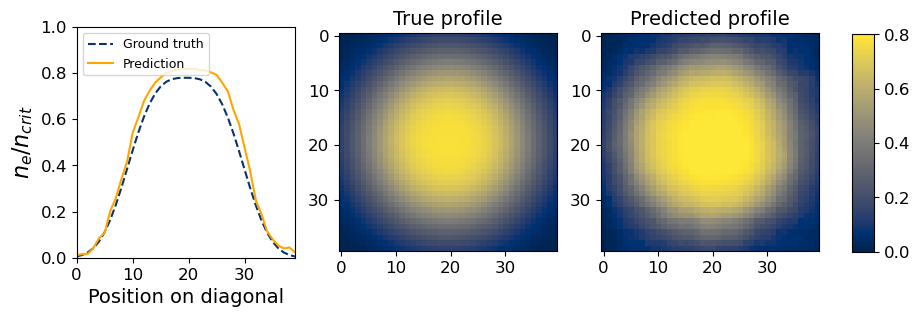

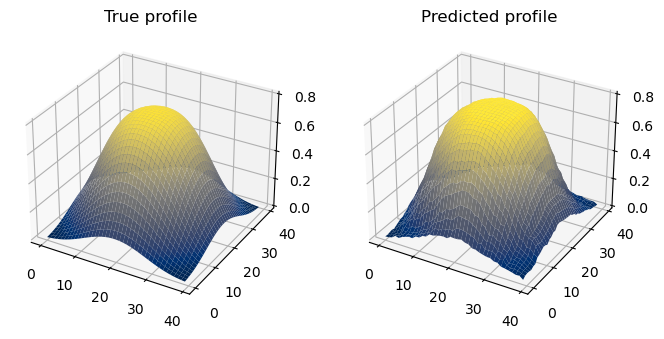

In [25]:
ResCompareProfiles(saved_resolved_a, x=x_test, y=y_test_new)

1/1 [==============================] - 0s 457ms/step
(40, 40)
tf.Tensor(0.020720936, shape=(), dtype=float32)


<Figure size 640x480 with 0 Axes>

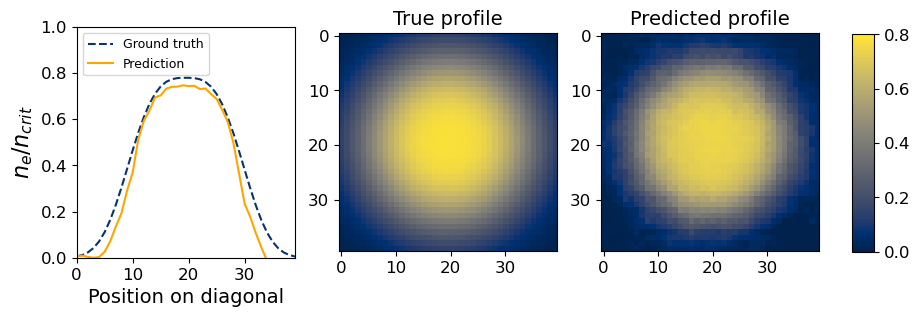

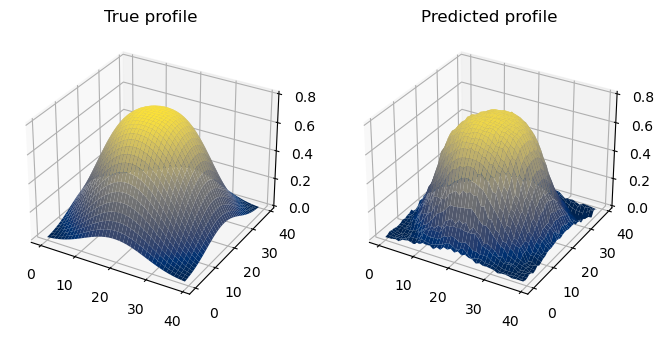

In [26]:
ResCompareProfiles(saved_resolved_2d, x=x_test_2, y=y_test_new)

1/1 [==============================] - 0s 290ms/step
(40, 40)
tf.Tensor(0.0070521086, shape=(), dtype=float32)


<Figure size 640x480 with 0 Axes>

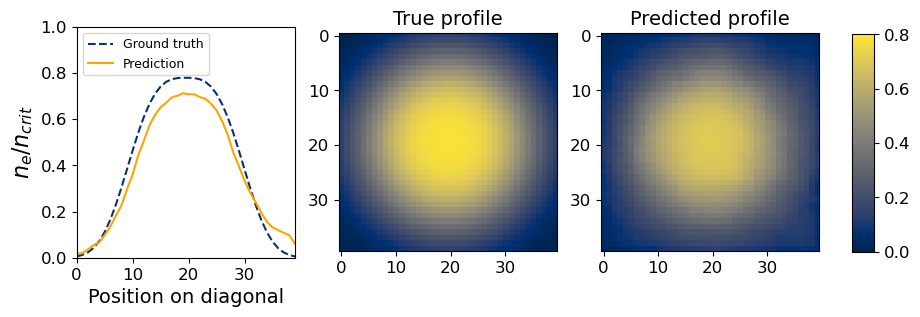

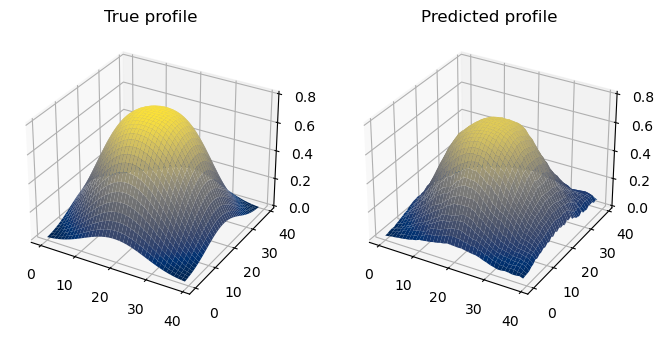

In [27]:
ResCompareProfiles(saved_resolved_PCA, x=x_pca_test, y=y_test_new)

# Quantitative comparison

All the fancy plotting was nice, but it's time to start comparing them in a more rigorous way. We have different measures to check for image similarity, so we can test these on the FDTD data first, and then also check comsol out.

### Get all the predicted profiles

In [24]:
predictions_par = np.array(saved_parametric.predict(x_test))


x = np.arange(605, 1445)
y = np.arange(605, 1445)

xv, yv = np.meshgrid(x, y, indexing='ij')

predictions_parametric = []


for i in range(predictions_par.shape[1]):
    if i%250==0:
        print(i)
    pars = predictions_par[:, i, 0]
    field = reduce_dimension(hypergaussian(pars[0], pars[1], pars[2], xv=xv, yv=yv), [40, 40])
    predictions_parametric.append(field)

predictions_parametric = np.array(predictions_parametric).reshape((-1, 40, 40, 1))

23/23 [==============================] - 0s 7ms/step
0
250
500


In [25]:
predictions_parametric.shape

(721, 40, 40, 1)

In [26]:
predictions_resolved = saved_resolved.predict(x_test) #.reshape(-1, 40, 40)
predictions_resolved_a = saved_resolved_a.predict(x_test)
predictions_resolved_2d = saved_resolved_2d.predict(x_test_2)
predictions_resolved_PCA = saved_resolved_PCA.predict(x_pca_test)

23/23 [==============================] - 0s 4ms/step


### Get MSE data

In [27]:
y_test_new.shape

(721, 40, 40)

In [28]:
MSE_parametric = mse(y_test_new, predictions_parametric.reshape(721, 40, 40))
MSE_resolved = mse(y_test_new, predictions_resolved.reshape(721, 40, 40))
MSE_resolved_a = mse(y_test_new, predictions_resolved_a.reshape(721, 40, 40))
MSE_resolved_2d = mse(y_test_new, predictions_resolved_2d.reshape(721, 40, 40))
MSE_resolved_PCA = mse(y_test_new, predictions_resolved_PCA.reshape(721, 40, 40))

In [29]:
MSE_parametric

<tf.Tensor: shape=(), dtype=float64, numpy=0.008674893691497286>

In [30]:
MSE = np.array((MSE_parametric, MSE_resolved, MSE_resolved_a, MSE_resolved_2d, MSE_resolved_PCA)).reshape((-1))

In [32]:
MSE.shape

(5,)

In [31]:
names = ['parametric', 'resolved_MSE', 'resolved MAE', 'resolved 2D', 'resolved PCA']
"""
fig, ax = plt.subplots()
for i, error in enumerate(MSE):
    ax.scatter(i, error)

ax.set_ylim(0, 0.01)
"""

def compare_metrics(losses, names=names, reverse=True):

    data = np.array([[loss, name] for loss, name in sorted(zip(losses, names), reverse=reverse)])

    plt.bar(range(len(names)), data[:, 0].astype(float))
    plt.xticks(range(len(names)), data[:,1], rotation=45)
    np.set_printoptions(False)
    plt.show()

    return

    


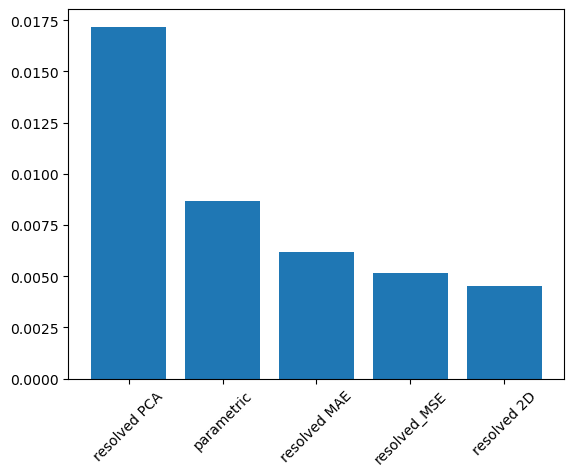

In [32]:
compare_metrics(MSE)

### Get SSIM data

In [33]:
SSIM_parametric = ssim_loss(y_test_new, predictions_parametric.reshape(721, 40, 40))
SSIM_resolved = ssim_loss(y_test_new, predictions_resolved.reshape(721, 40, 40))
SSIM_resolved_a = ssim_loss(y_test_new, predictions_resolved_a.reshape(721, 40, 40))
SSIM_resolved_2d = ssim_loss(y_test_new, predictions_resolved_2d.reshape(721, 40, 40))
SSIM_resolved_PCA = ssim_loss(y_test_new, predictions_resolved_PCA.reshape(721, 40, 40))

SSIM = (SSIM_parametric, SSIM_resolved, SSIM_resolved_a, SSIM_resolved_2d, SSIM_resolved_PCA)

C:\Users\ewout\AppData\Local\Temp\ipykernel_20336\239273156.py:7: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return  ssim(y_true, y_pred, multichannel=True)
c:\Users\ewout\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


In [34]:
SSIM_parametric

0.8249008878157623

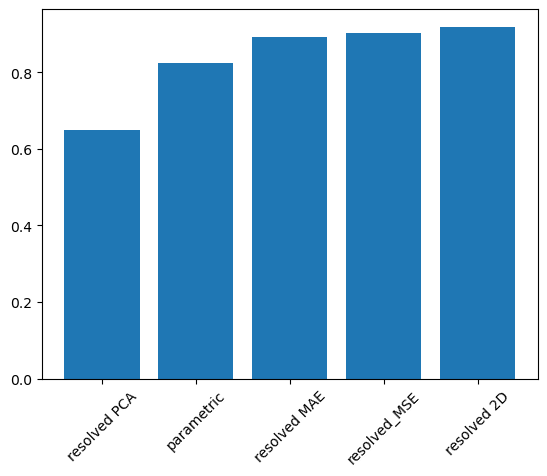

In [35]:
compare_metrics(SSIM, reverse=False)

### Get Psnr

In [36]:
PSNR_parametric = psnr(y_test_new, predictions_parametric.reshape(721, 40, 40))
PSNR_resolved = psnr(y_test_new, predictions_resolved.reshape(721, 40, 40))
PSNR_resolved_a = psnr(y_test_new, predictions_resolved_a.reshape(721, 40, 40))
PSNR_resolved_2d = psnr(y_test_new, predictions_resolved_2d.reshape(721, 40, 40))
PSNR_resolved_PCA = psnr(y_test_new, predictions_resolved_PCA.reshape(721, 40, 40))

PSNR = np.array((PSNR_parametric, PSNR_resolved, PSNR_resolved_a, PSNR_resolved_2d, PSNR_resolved_PCA))

In [37]:
PSNR.shape

(5,)

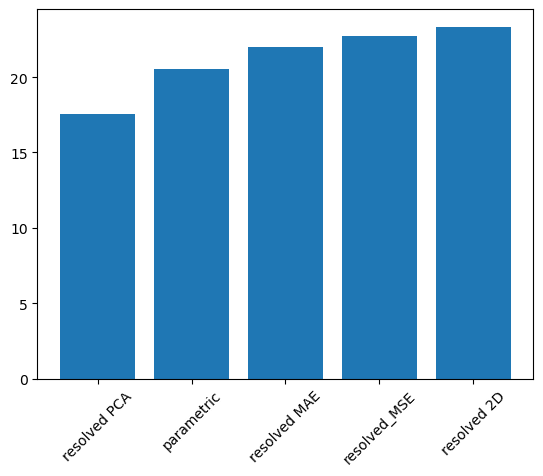

In [38]:
compare_metrics(PSNR, reverse=False)

### Get cos sim

In [39]:
COS_parametric = cosine_similarity(y_test_new, predictions_parametric.reshape(721, 40, 40))
COS_resolved = cosine_similarity(y_test_new, predictions_resolved.reshape(721, 40, 40))
COS_resolved_a = cosine_similarity(y_test_new, predictions_resolved_a.reshape(721, 40, 40))
COS_resolved_2d = cosine_similarity(y_test_new, predictions_resolved_2d.reshape(721, 40, 40))
COS_resolved_PCA = cosine_similarity(y_test_new, predictions_resolved_PCA.reshape(721, 40, 40))

COS = np.array((COS_parametric, COS_resolved, COS_resolved_a, COS_resolved_2d, COS_resolved_PCA))

In [40]:
COS_parametric

<tf.Tensor: shape=(), dtype=float32, numpy=0.01933874>

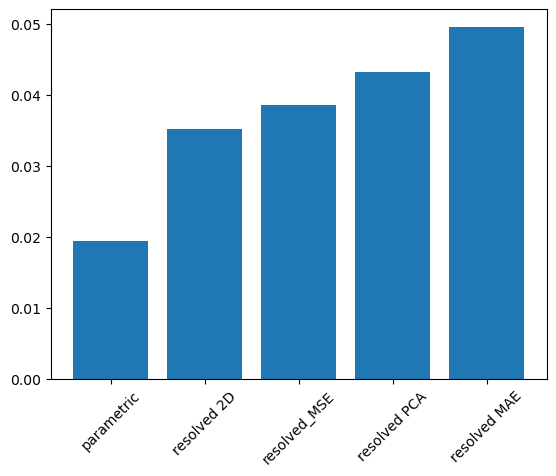

In [41]:
compare_metrics(COS, reverse=False)

This tells us what we already know, even though they might look reasonably similar (MSE is okay, so is PSNR and SSIM) but the cosine similarity really checks how close each corresponding pixel is. As the parametric model will systematically over or undershoot (as opposed to the rather averaging effect in the resolved cases) it really performs a lot worse on this measure. So it structurally over or undershoots, something which the SSIM doesn't really care about to the same extent as long as it 'looks good'. MSE also doesn't care, over and undershooting is coing to cause the same error.

### Get MAPE

In [42]:
mae_parametric = mae(y_test_new, predictions_parametric.reshape(721, 40, 40))
mae_resolved = mae(y_test_new, predictions_resolved.reshape(721, 40, 40))
mae_resolved_a = mae(y_test_new, predictions_resolved_a.reshape(721, 40, 40))
mae_resolved_2d = mae(y_test_new, predictions_resolved_2d.reshape(721, 40, 40))
mae_resolved_PCA = mae(y_test_new, predictions_resolved_PCA.reshape(721, 40, 40))

MAE = np.array((mae_parametric, mae_resolved, mae_resolved_a, mae_resolved_2d, mae_resolved_PCA))

In [43]:
mae_parametric

<tf.Tensor: shape=(), dtype=float64, numpy=0.06094154705296501>

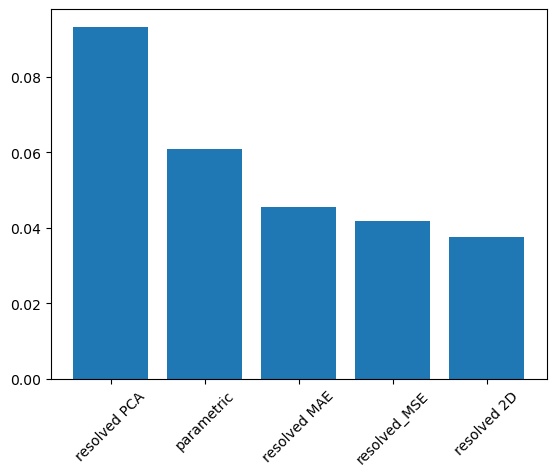

In [44]:
compare_metrics(MAE, reverse=True)

### See where the trend lies

In [45]:
def get_peak(elem):
    return elem[0]

y_sorted = np.array([[peak.astype(np.float64), resolved] for peak, resolved in sorted(zip(y_test[:, 0], y_test_new), key=get_peak)])
pred_resolved_sorted = np.array(sorted(zip(y_test[:, 0], predictions_resolved_a), key=get_peak))
pred_parametric_sorted = np.array(sorted(zip(y_test[:, 0], predictions_parametric), key=get_peak))

C:\Users\ewout\AppData\Local\Temp\ipykernel_20336\2144855323.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_sorted = np.array([[peak.astype(np.float64), resolved] for peak, resolved in sorted(zip(y_test[:, 0], y_test_new), key=get_peak)])
C:\Users\ewout\AppData\Local\Temp\ipykernel_20336\2144855323.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pred_resolved_sorted = np.array(sorted(zip(y_test[:, 0], predictions_resolved_a), key=get_peak))
C:\Users\ewout\AppData\Local\Temp\ipykernel_20336\2144855323.py:6: VisibleDeprecationWarning: Creati

In [46]:
MAE_sorted_resolved = []
MAE_sorted_parametric = []
densities = y_sorted[:, 0]

#for i in range(550):
for i in range(len(densities)):

    error_res = mae(y_sorted[i, 1].reshape((40, 40, 1)), pred_resolved_sorted[i, 1])
    error_par = mae(y_sorted[i, 1].reshape((40, 40, 1)), pred_parametric_sorted[i, 1])
    MAE_sorted_resolved.append(error_res)
    MAE_sorted_parametric.append(error_par)

In [47]:
densities[550] #best performance up to here.

0.598

In [48]:
np.mean(MAE_sorted_resolved)

0.04562167405644646

In [61]:
import scipy.optimize as optimize
def func(x, a, b): 
    return a * np.exp(b * x.astype(np.float64)) 
  
# Fit the exponential function to the data points  
params, params_covariance = optimize.curve_fit(func, densities, MAE_sorted_resolved) 

 # Plot the data points and the fitted curve 


In [ ]:
densities.dtype

dtype('O')

float64


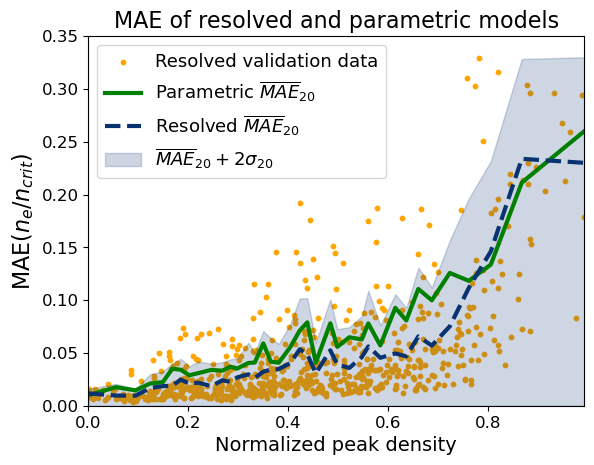

In [50]:
fig, ax = plt.subplots()

ax.scatter(densities, MAE_sorted_resolved, s=10, c='orange', label='Resolved validation data')
#ax.scatter(densities, MAE_sorted_parametric, s=4, c='indianred', label = 'Parametric')


mean_20 = [] 
mean_20_b = [] 
stdev_20 = []

for i in range(0 , len(MAE_sorted_resolved), 20): 
    #// Also calculate the standard deviation of the 20 points
    mean_20_points = sum(MAE_sorted_resolved[i:i+20])/20  # Calculate mean of 10 points  
    mean_20_b_points = sum(MAE_sorted_parametric[i:i+20])/20
    mean_20 .append(mean_20_points) # Append the values in the list  
    mean_20_b .append(mean_20_b_points)

    variance_20 = sum(((MAE_sorted_resolved[i:i+20] - mean_20_b_points) ** 2)) / 20 
    stdev_20 .append(variance_20**0.5)

mean_20[-1] = 0.23
mean_20_b[-1] = 0.26
stdev_20[-1] = 0.1


     # Plot the line graph
ax .plot(densities[::20],mean_20_b, c='green', linewidth=3, label=r'Parametric $\overline{MAE}_{20}$')  
ax .plot(densities[::20],mean_20, c=colors[0], linewidth=3, linestyle='--', label=r'Resolved $\overline{MAE}_{20}$')
ax.fill_between(np.array(densities[::20], dtype=float), 0,
 np.array(mean_20, dtype=float) + np.array(stdev_20, dtype=float), color=colors[0], alpha=0.2, label=r'$\overline{MAE}_{20} + 2\sigma_{20}$')

ax.legend(loc='upper left', fontsize=13)
ax.set_ylim((0, 0.35))
ax.set_xlim((0, densities[::20][-1]))

ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('MAE of resolved and parametric models', fontsize=16)
ax.set_xlabel(r'Normalized peak density', fontsize=14)
ax.set_ylabel(r'MAE($n_e/n_{crit}$)', fontsize=16)


print(np.array(densities[::20], dtype=float).dtype)

#// perform a fit of an exponential function to both the scatterplots above.

#ax.yscale('log')
#ax.ylim(1e-5, 1)

Try to find the best type of plot here, get a regression

Also switch to a absolute percentage error!

# Comsol data, testing!

In [212]:
from scipy import interpolate


In [235]:
comsol = np.loadtxt('half_wavelength.txt', skiprows=8)[:, 1:]
comsol_no_plasma = np.loadtxt('comsol_quartz.txt', skiprows=8)[:, 1:]
comsol.shape

(1008, 539)

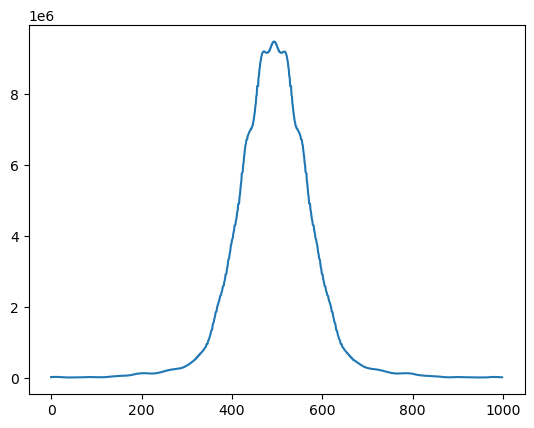

In [236]:
plt.plot(comsol_no_plasma)

In [237]:
x_train.shape

(2881, 1023, 1)

In [238]:
def interpolate_comsol(comsol, x_train):
    x = np.linspace(0, x_train[0].shape[0], comsol.shape[0])
    x_new = np.arange(0, x_train[0].shape[0])

    dens = []

    for i in range(0, comsol.shape[1]):
        
        y_new = interpolate.interp1d(x, comsol[:, i])(x_new)
        dens.append(y_new)

    dens = np.array(dens)
    return dens

In [239]:
def preProcessing_comsol(y_df, X_comsol, no_plasma, comps=5, noise=False, var_noise=0.01):

    no_plasma = interpolate_comsol(no_plasma, x_train)
    
    X_comsol = interpolate_comsol(X_comsol, x_train)

    X_comsol -= no_plasma

    X = np.expand_dims(np.array(X_comsol), -1) #needed for the convolutional structure
    y = np.array(y_df)

    
    highest_peak = np.amax(abs(X))
    print(highest_peak)
    print(np.amin(X))
    X /= highest_peak

    new_max = np.amax(abs(X))
    print(new_max)
    #get all the data to be normalized in a sense, to have the largest absolute value of 1
    #then the standard deviation of the noise you add is 1% of this max, quite substantial!
    
    if noise:
        for i, sample in enumerate(X):
            X[i] = add_noise(sample, var_noise*new_max)

    pca = PCA(n_components=comps)
    pca.fit(X[:, :-1, 0])

    X_pca = pca.transform(X[:, :-1, 0])

    return X, X_pca, y

In [240]:
comsol, comsol_pca, y_comsol = preProcessing_comsol(y, comsol, no_plasma=comsol_no_plasma, noise=False)

9471717.71066911
-9471717.71066911
1.0


In [241]:
comsol.shape

(539, 1023, 1)

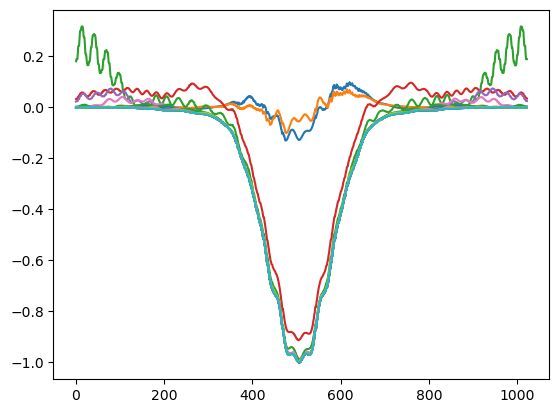

In [242]:
for i in range(0, 500, 25):
    plt.plot(comsol[i])

In [252]:
z_pred = saved_resolved_a.predict(np.expand_dims(comsol[0], 0)).reshape((40, 40))
prediction = saved_parametric.predict(np.expand_dims(comsol[0], 0))
truth = np.array([0.05, 0.6, 2])

1/1 [==============================] - 0s 19ms/step


In [253]:
#z_pred = reduce_dimension(hypergaussian(prediction[0], prediction[1], prediction[2], xv=xv, yv=yv), [40, 40])
z_true = reduce_dimension(hypergaussian(truth[0], truth[1], truth[2], xv=xv, yv=yv), [40, 40])

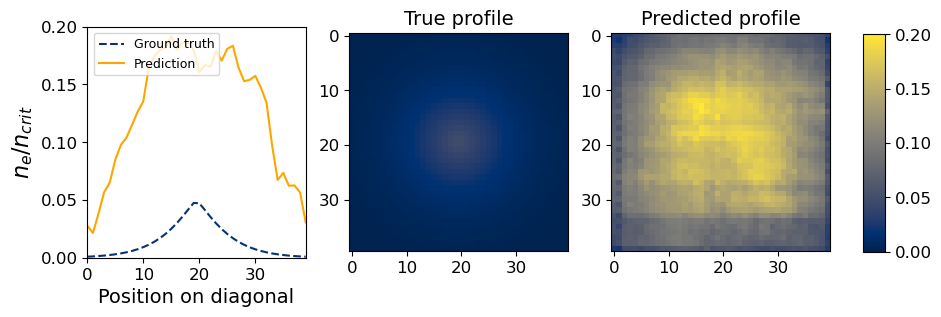

In [254]:
fig, ax = plt.subplots(1, 3, figsize=(11, 3))

im_true = ax[0].plot(np.diag(z_true), label='Ground truth', linestyle='--', c=colors[0])
ax[0].set_xlabel('Position on diagonal', fontsize=14)
ax[0].set_ylabel(r'$n_e/n_{crit}$', fontsize=16)

ax[0].plot(np.diag(z_pred), label='Prediction', c='orange')
ax[0].set_xlim((0, 39))
ax[0].set_ylim((0, .2))
ax[0].legend(loc='upper left', fontsize=9)
ax[0].tick_params(axis='both', which='major', labelsize=12)
#//set the ticksize to 12 for the above figure ax[0]
#plt.colorbar(im_true)

max_value = np.max([z_true.max(), z_pred.max()])
min_value = np.min([z_true.min(), z_pred.min()])

#change to max and min_value to see more clear differences. But this maybe hits the point home
#that we have really good agreement.
true = ax[1].imshow(z_true, vmax=0.2, vmin=0)
ax[1].set_title('True profile', fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=12)

ax[2].imshow(z_pred, vmax=0.2, vmin=0)
ax[2].set_title('Predicted profile', fontsize=14)
ax[2].tick_params(axis='both', which='major', labelsize=12)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.13, 0.02, 0.725])
cbar = fig.colorbar(true, cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)

plt.show()